# 3년치 데이터 역방향 학습& 예측(최근 트랜드 반영)

In [1]:
!pip install tf-nightly

In [2]:
import tensorflow as tf
import tensorflow.keras.layers
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


train data % : 1.5 test data % : 79.88
Epoch 1/500
17/17 [==============================] - 5s 77ms/step - loss: 0.5729 - accuracy: 0.7693 - val_loss: 2.1716 - val_accuracy: 0.1712

Epoch 00001: loss improved from inf to 0.43393, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_02r.hdf5
Epoch 2/500
17/17 [==============================] - 1s 33ms/step - loss: 0.1307 - accuracy: 0.9830 - val_loss: 5.2213 - val_accuracy: 0.1712

Epoch 00002: loss improved from 0.43393 to 0.11301, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_02r.hdf5
Epoch 3/500
17/17 [==============================] - 1s 33ms/step - loss: 0.1240 - accuracy: 0.9846 - val_loss: 4.5541 - val_accuracy: 0.1712

Epoch 00003: loss did not improve from 0.11301
Epoch 4/500
17/17 [==============================] - 1s 34ms/step - loss: 0.1281 - accuracy: 0.9813 - val_loss: 3.6513 - val_accuracy: 0.1712

Epoch 00004: loss improved from 0.11301 to 0.09468, saving model to /content/gdrive/My

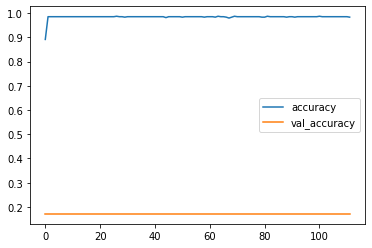

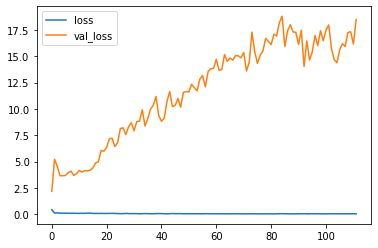

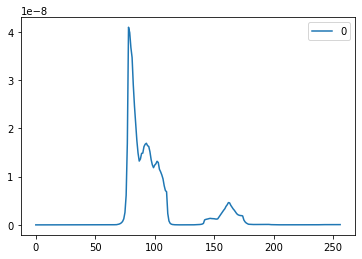

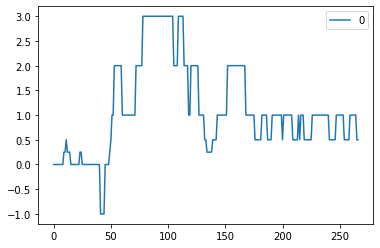

In [3]:
df = pd.read_csv("/content/gdrive/My Drive/SBUX_rev.2.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-240)- df['mov5'].shift(-239))/df['mov5'].shift(-240)
df['1w'] = (df['mov5'].shift(-240)- df['mov5'].shift(-235))/df['mov5'].shift(-240)
df['2w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-230))/df['mov5'].shift(-240)
df['4w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-220))/df['mov5'].shift(-240)
df['6w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-210))/df['mov5'].shift(-240)
df['8w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-200))/df['mov5'].shift(-240)
df['10w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-190))/df['mov5'].shift(-240)
df['12w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-180))/df['mov5'].shift(-240)
df['18w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-150))/df['mov5'].shift(-240)
df['24w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-120))/df['mov5'].shift(-240)
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5'].shift(-240)

df['1d'] = df['1d'].shift(240)
df['1w'] =df['1w'].shift(240)
df['2w'] = df['2w'].shift(240)
df['4w'] = df['4w'].shift(240)
df['6w'] = df['6w'].shift(240)
df['8w'] = df['8w'].shift(240)
df['10w'] = df['10w'].shift(240)
df['12w'] = df['12w'].shift(240)
df['18w'] = df['18w'].shift(240)
df['24w'] = df['24w'].shift(240)
df['48w'] = df['48w'].shift(240)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)
df = df.iloc[-800:,:]

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

from tensorflow.keras.callbacks import ModelCheckpoint

modelpath = "/content/gdrive/My Drive/Colab Notebooks/model/stock_02r.hdf5"
checkpointer = ModelCheckpoint(filepath = modelpath, monitor = 'loss', verbose = 1, save_best_only = True)

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'loss', patience = 30)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU

# EnSemble을 만들기 위한 사전 작업 : model1 : 전체 데이터 작업

i = Input(shape=(T,D))

lstm = LSTM(100, dropout=0.4, recurrent_dropout=0.4)
left_input = Input(shape=(T,D))
left_output = lstm(left_input)

gru = GRU(100,  dropout=0.4, recurrent_dropout=0.4)
right_input = Input(shape= (T,D))
right_output = gru(right_input)

# merge
merged = tf.keras.layers.concatenate([left_output, right_output], axis = -1)
merged = Dropout(rate=0.7)(merged)
merged = Dense(256, activation='relu')(merged)
merged = Dropout(rate=0.7)(merged)
merged = Dense(5, LeakyReLU(alpha=0.1))(merged)
predictions = tf.keras.layers.Dense(1, activation = 'sigmoid')(merged)


model = Model([left_input, right_input], predictions)

model.compile(
    loss = 'binary_crossentropy',
    sample_weight_mode = 'temporal',
    optimizer = Adam(lr = 0.001),
    metrics = ['accuracy'],
)


# 모델 객체 만들고 훈련

r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 32,
          epochs = 500,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_train, X_train])).plot()
pd.DataFrame(target[:Ntrain]).plot()


train data % : 0.9400000000000001 test data % : 24.75
Epoch 1/500
17/17 [==============================] - 3s 64ms/step - loss: 0.0567 - accuracy: 0.9887 - val_loss: 4.5073 - val_accuracy: 0.7432

Epoch 00001: loss did not improve from 0.02576
Epoch 2/500
17/17 [==============================] - 1s 32ms/step - loss: 0.0632 - accuracy: 0.9906 - val_loss: 3.3373 - val_accuracy: 0.7432

Epoch 00002: loss did not improve from 0.02576
Epoch 3/500
17/17 [==============================] - 1s 34ms/step - loss: 0.0764 - accuracy: 0.9906 - val_loss: 3.0434 - val_accuracy: 0.7432

Epoch 00003: loss did not improve from 0.02576
Epoch 4/500
17/17 [==============================] - 1s 33ms/step - loss: 0.0637 - accuracy: 0.9906 - val_loss: 2.0649 - val_accuracy: 0.7432

Epoch 00004: loss did not improve from 0.02576
Epoch 5/500
17/17 [==============================] - 1s 33ms/step - loss: 0.0537 - accuracy: 0.9906 - val_loss: 2.5983 - val_accuracy: 0.7432

Epoch 00005: loss did not improve from 0.02

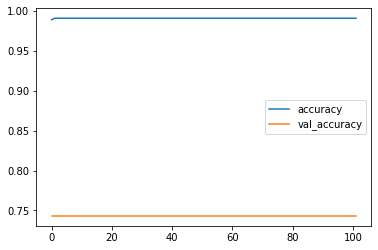

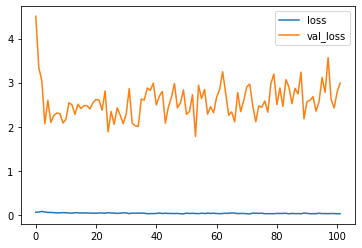

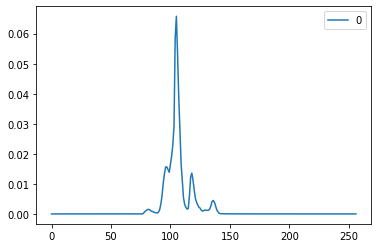

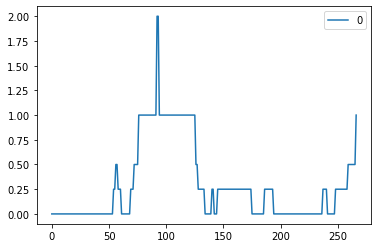

In [4]:
df = pd.read_csv("/content/gdrive/My Drive/AMZN.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-240)- df['mov5'].shift(-239))/df['mov5'].shift(-240)
df['1w'] = (df['mov5'].shift(-240)- df['mov5'].shift(-235))/df['mov5'].shift(-240)
df['2w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-230))/df['mov5'].shift(-240)
df['4w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-220))/df['mov5'].shift(-240)
df['6w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-210))/df['mov5'].shift(-240)
df['8w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-200))/df['mov5'].shift(-240)
df['10w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-190))/df['mov5'].shift(-240)
df['12w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-180))/df['mov5'].shift(-240)
df['18w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-150))/df['mov5'].shift(-240)
df['24w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-120))/df['mov5'].shift(-240)
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5'].shift(-240)

df['1d'] = df['1d'].shift(240)
df['1w'] =df['1w'].shift(240)
df['2w'] = df['2w'].shift(240)
df['4w'] = df['4w'].shift(240)
df['6w'] = df['6w'].shift(240)
df['8w'] = df['8w'].shift(240)
df['10w'] = df['10w'].shift(240)
df['12w'] = df['12w'].shift(240)
df['18w'] = df['18w'].shift(240)
df['24w'] = df['24w'].shift(240)
df['48w'] = df['48w'].shift(240)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)
df = df.iloc[-800:,:]

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] =(target [t+T]>0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02r.hdf5")

# 모델 객체 만들고 훈련
r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 32,
          epochs = 500,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_train, X_train])).plot()
pd.DataFrame(target[:Ntrain]).plot()



train data % : 22.5 test data % : 24.75
Epoch 1/500
17/17 [==============================] - 3s 61ms/step - loss: 0.7685 - accuracy: 0.7711 - val_loss: 0.5546 - val_accuracy: 0.7432

Epoch 00001: loss did not improve from 0.01953
Epoch 2/500
17/17 [==============================] - 1s 33ms/step - loss: 0.4402 - accuracy: 0.7749 - val_loss: 0.4228 - val_accuracy: 0.7432

Epoch 00002: loss did not improve from 0.01953
Epoch 3/500
17/17 [==============================] - 1s 33ms/step - loss: 0.4052 - accuracy: 0.7749 - val_loss: 0.3856 - val_accuracy: 0.7432

Epoch 00003: loss did not improve from 0.01953
Epoch 4/500
17/17 [==============================] - 1s 34ms/step - loss: 0.3840 - accuracy: 0.7749 - val_loss: 0.3847 - val_accuracy: 0.7432

Epoch 00004: loss did not improve from 0.01953
Epoch 5/500
17/17 [==============================] - 1s 33ms/step - loss: 0.3572 - accuracy: 0.7730 - val_loss: 0.3564 - val_accuracy: 0.7432

Epoch 00005: loss did not improve from 0.01953
Epoch 6/50

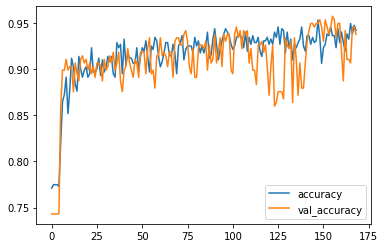

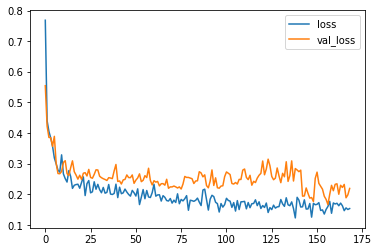

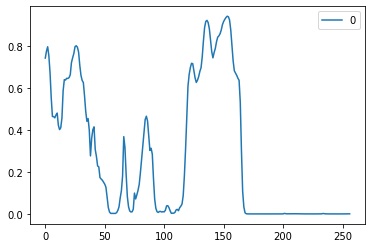

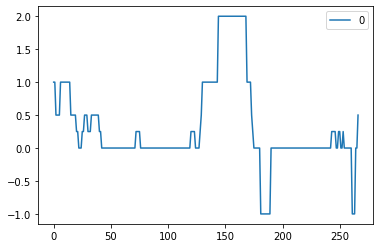

In [5]:
df = pd.read_csv("/content/gdrive/My Drive/TSLA.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-240)- df['mov5'].shift(-239))/df['mov5'].shift(-240)
df['1w'] = (df['mov5'].shift(-240)- df['mov5'].shift(-235))/df['mov5'].shift(-240)
df['2w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-230))/df['mov5'].shift(-240)
df['4w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-220))/df['mov5'].shift(-240)
df['6w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-210))/df['mov5'].shift(-240)
df['8w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-200))/df['mov5'].shift(-240)
df['10w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-190))/df['mov5'].shift(-240)
df['12w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-180))/df['mov5'].shift(-240)
df['18w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-150))/df['mov5'].shift(-240)
df['24w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-120))/df['mov5'].shift(-240)
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5'].shift(-240)

df['1d'] = df['1d'].shift(240)
df['1w'] =df['1w'].shift(240)
df['2w'] = df['2w'].shift(240)
df['4w'] = df['4w'].shift(240)
df['6w'] = df['6w'].shift(240)
df['8w'] = df['8w'].shift(240)
df['10w'] = df['10w'].shift(240)
df['12w'] = df['12w'].shift(240)
df['18w'] = df['18w'].shift(240)
df['24w'] = df['24w'].shift(240)
df['48w'] = df['48w'].shift(240)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)
df = df.iloc[-800:,:]

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] =(target [t+T]>0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02r.hdf5")

# 모델 객체 만들고 훈련
r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 32,
          epochs = 500,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()
pd.DataFrame(model.predict([X_train, X_train])).plot()
pd.DataFrame(target[:Ntrain]).plot()


train data % : 0.38 test data % : 60.38
Epoch 1/500
17/17 [==============================] - 3s 61ms/step - loss: 0.0802 - accuracy: 0.9962 - val_loss: 6.4749 - val_accuracy: 0.3735

Epoch 00001: loss did not improve from 0.01953
Epoch 2/500
17/17 [==============================] - 1s 33ms/step - loss: 0.0480 - accuracy: 0.9962 - val_loss: 5.7324 - val_accuracy: 0.3735

Epoch 00002: loss did not improve from 0.01953
Epoch 3/500
17/17 [==============================] - 1s 32ms/step - loss: 0.0392 - accuracy: 0.9962 - val_loss: 5.0491 - val_accuracy: 0.3735

Epoch 00003: loss did not improve from 0.01953
Epoch 4/500
17/17 [==============================] - 1s 47ms/step - loss: 0.0343 - accuracy: 0.9962 - val_loss: 4.4205 - val_accuracy: 0.3735

Epoch 00004: loss did not improve from 0.01953
Epoch 5/500
17/17 [==============================] - 1s 32ms/step - loss: 0.0303 - accuracy: 0.9962 - val_loss: 4.1979 - val_accuracy: 0.3735

Epoch 00005: loss did not improve from 0.01953
Epoch 6/50

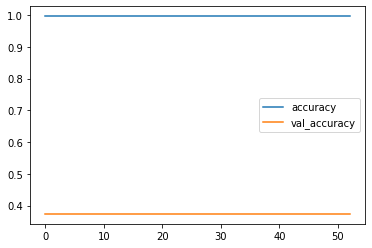

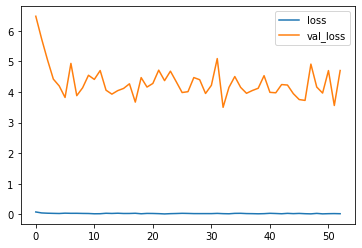

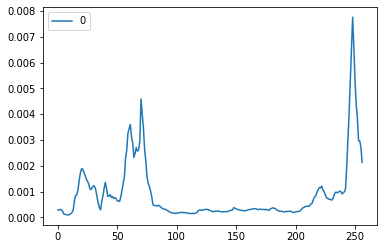

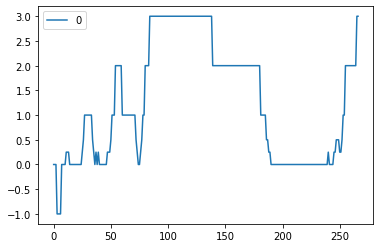

In [6]:
df = pd.read_csv("/content/gdrive/My Drive/AAPL.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-240)- df['mov5'].shift(-239))/df['mov5'].shift(-240)
df['1w'] = (df['mov5'].shift(-240)- df['mov5'].shift(-235))/df['mov5'].shift(-240)
df['2w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-230))/df['mov5'].shift(-240)
df['4w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-220))/df['mov5'].shift(-240)
df['6w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-210))/df['mov5'].shift(-240)
df['8w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-200))/df['mov5'].shift(-240)
df['10w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-190))/df['mov5'].shift(-240)
df['12w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-180))/df['mov5'].shift(-240)
df['18w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-150))/df['mov5'].shift(-240)
df['24w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-120))/df['mov5'].shift(-240)
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5'].shift(-240)

df['1d'] = df['1d'].shift(240)
df['1w'] =df['1w'].shift(240)
df['2w'] = df['2w'].shift(240)
df['4w'] = df['4w'].shift(240)
df['6w'] = df['6w'].shift(240)
df['8w'] = df['8w'].shift(240)
df['10w'] = df['10w'].shift(240)
df['12w'] = df['12w'].shift(240)
df['18w'] = df['18w'].shift(240)
df['24w'] = df['24w'].shift(240)
df['48w'] = df['48w'].shift(240)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)
df = df.iloc[-800:,:]

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result


df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] =(target [t+T]>0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02r.hdf5")

# 모델 객체 만들고 훈련
r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 32,
          epochs = 500,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_train, X_train])).plot()
pd.DataFrame(target[:Ntrain]).plot()


train data % : 6.38 test data % : 53.25
Epoch 1/500
17/17 [==============================] - 3s 61ms/step - loss: 0.2568 - accuracy: 0.9362 - val_loss: 1.6115 - val_accuracy: 0.4475

Epoch 00001: loss did not improve from 0.01623
Epoch 2/500
17/17 [==============================] - 1s 32ms/step - loss: 0.2136 - accuracy: 0.9362 - val_loss: 2.7268 - val_accuracy: 0.4475

Epoch 00002: loss did not improve from 0.01623
Epoch 3/500
17/17 [==============================] - 1s 33ms/step - loss: 0.1844 - accuracy: 0.9362 - val_loss: 2.9819 - val_accuracy: 0.4475

Epoch 00003: loss did not improve from 0.01623
Epoch 4/500
17/17 [==============================] - 1s 33ms/step - loss: 0.1735 - accuracy: 0.9362 - val_loss: 3.0788 - val_accuracy: 0.4475

Epoch 00004: loss did not improve from 0.01623
Epoch 5/500
17/17 [==============================] - 1s 32ms/step - loss: 0.1779 - accuracy: 0.9362 - val_loss: 2.7561 - val_accuracy: 0.4475

Epoch 00005: loss did not improve from 0.01623
Epoch 6/50

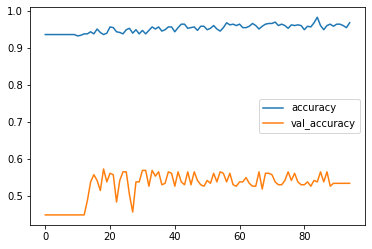

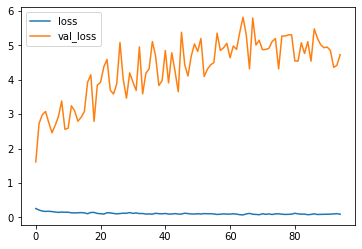

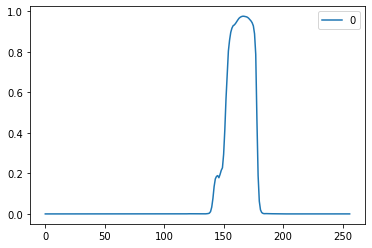

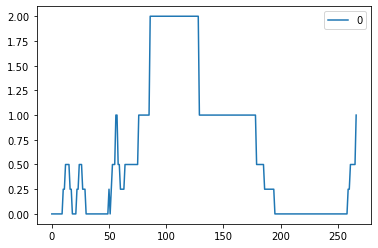

In [7]:
df = pd.read_csv("/content/gdrive/My Drive/INTC.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-240)- df['mov5'].shift(-239))/df['mov5'].shift(-240)
df['1w'] = (df['mov5'].shift(-240)- df['mov5'].shift(-235))/df['mov5'].shift(-240)
df['2w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-230))/df['mov5'].shift(-240)
df['4w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-220))/df['mov5'].shift(-240)
df['6w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-210))/df['mov5'].shift(-240)
df['8w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-200))/df['mov5'].shift(-240)
df['10w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-190))/df['mov5'].shift(-240)
df['12w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-180))/df['mov5'].shift(-240)
df['18w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-150))/df['mov5'].shift(-240)
df['24w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-120))/df['mov5'].shift(-240)
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5'].shift(-240)

df['1d'] = df['1d'].shift(240)
df['1w'] =df['1w'].shift(240)
df['2w'] = df['2w'].shift(240)
df['4w'] = df['4w'].shift(240)
df['6w'] = df['6w'].shift(240)
df['8w'] = df['8w'].shift(240)
df['10w'] = df['10w'].shift(240)
df['12w'] = df['12w'].shift(240)
df['18w'] = df['18w'].shift(240)
df['24w'] = df['24w'].shift(240)
df['48w'] = df['48w'].shift(240)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)
df = df.iloc[-800:,:]

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] =(target [t+T]>0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02r.hdf5")

# 모델 객체 만들고 훈련
r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 32,
          epochs = 500,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_train, X_train])).plot()
pd.DataFrame(target[:Ntrain]).plot()


train data % : 32.62 test data % : 78.75
Epoch 1/500
17/17 [==============================] - 3s 62ms/step - loss: 0.8399 - accuracy: 0.6735 - val_loss: 0.8253 - val_accuracy: 0.1829

Epoch 00001: loss did not improve from 0.01623
Epoch 2/500
17/17 [==============================] - 1s 34ms/step - loss: 0.5666 - accuracy: 0.7373 - val_loss: 1.6130 - val_accuracy: 0.1829

Epoch 00002: loss did not improve from 0.01623
Epoch 3/500
17/17 [==============================] - 1s 32ms/step - loss: 0.4749 - accuracy: 0.7936 - val_loss: 1.9695 - val_accuracy: 0.1829

Epoch 00003: loss did not improve from 0.01623
Epoch 4/500
17/17 [==============================] - 1s 32ms/step - loss: 0.4788 - accuracy: 0.7992 - val_loss: 1.6276 - val_accuracy: 0.1829

Epoch 00004: loss did not improve from 0.01623
Epoch 5/500
17/17 [==============================] - 1s 35ms/step - loss: 0.4872 - accuracy: 0.7917 - val_loss: 1.6155 - val_accuracy: 0.2296

Epoch 00005: loss did not improve from 0.01623
Epoch 6/5

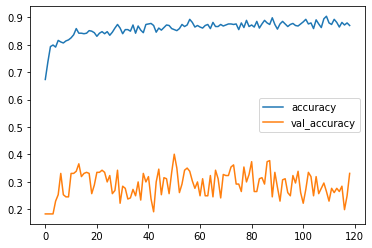

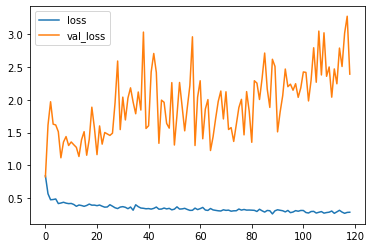

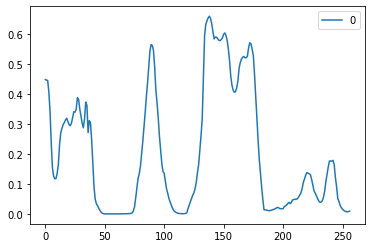

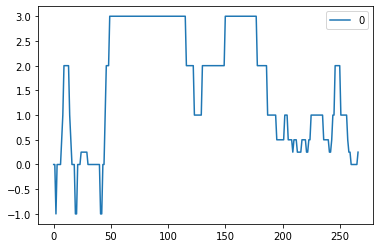

In [8]:
df = pd.read_csv("/content/gdrive/My Drive/AMD.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-240)- df['mov5'].shift(-239))/df['mov5'].shift(-240)
df['1w'] = (df['mov5'].shift(-240)- df['mov5'].shift(-235))/df['mov5'].shift(-240)
df['2w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-230))/df['mov5'].shift(-240)
df['4w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-220))/df['mov5'].shift(-240)
df['6w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-210))/df['mov5'].shift(-240)
df['8w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-200))/df['mov5'].shift(-240)
df['10w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-190))/df['mov5'].shift(-240)
df['12w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-180))/df['mov5'].shift(-240)
df['18w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-150))/df['mov5'].shift(-240)
df['24w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-120))/df['mov5'].shift(-240)
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5'].shift(-240)

df['1d'] = df['1d'].shift(240)
df['1w'] =df['1w'].shift(240)
df['2w'] = df['2w'].shift(240)
df['4w'] = df['4w'].shift(240)
df['6w'] = df['6w'].shift(240)
df['8w'] = df['8w'].shift(240)
df['10w'] = df['10w'].shift(240)
df['12w'] = df['12w'].shift(240)
df['18w'] = df['18w'].shift(240)
df['24w'] = df['24w'].shift(240)
df['48w'] = df['48w'].shift(240)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)
df = df.iloc[-800:,:]

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

from tensorflow.keras.callbacks import ModelCheckpoint

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] =(target [t+T]>0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02r.hdf5")

# 모델 객체 만들고 훈련
r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 32,
          epochs = 500,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_train, X_train])).plot()
pd.DataFrame(target[:Ntrain]).plot()


train data % : 1.5 test data % : 79.88
Epoch 1/500
17/17 [==============================] - 3s 63ms/step - loss: 0.0852 - accuracy: 0.9850 - val_loss: 4.7389 - val_accuracy: 0.1712

Epoch 00001: loss did not improve from 0.01623
Epoch 2/500
17/17 [==============================] - 1s 31ms/step - loss: 0.0740 - accuracy: 0.9850 - val_loss: 5.5304 - val_accuracy: 0.1712

Epoch 00002: loss did not improve from 0.01623
Epoch 3/500
17/17 [==============================] - 1s 32ms/step - loss: 0.0697 - accuracy: 0.9850 - val_loss: 6.3153 - val_accuracy: 0.1712

Epoch 00003: loss did not improve from 0.01623
Epoch 4/500
17/17 [==============================] - 1s 33ms/step - loss: 0.0694 - accuracy: 0.9850 - val_loss: 6.9979 - val_accuracy: 0.1712

Epoch 00004: loss did not improve from 0.01623
Epoch 5/500
17/17 [==============================] - 1s 32ms/step - loss: 0.0520 - accuracy: 0.9850 - val_loss: 7.9523 - val_accuracy: 0.1712

Epoch 00005: loss did not improve from 0.01623
Epoch 6/500

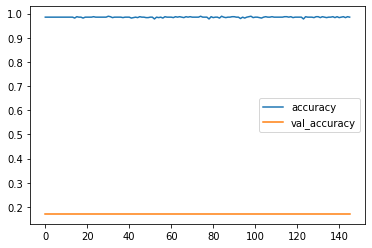

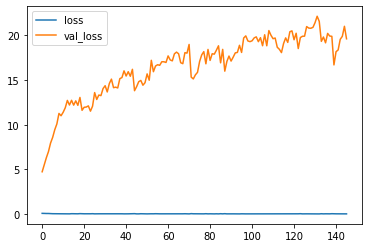

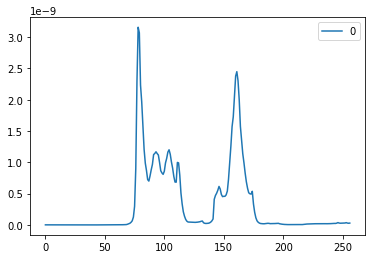

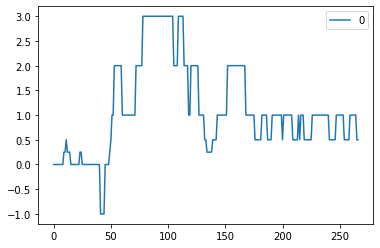

In [9]:
df = pd.read_csv("/content/gdrive/My Drive/SBUX_rev.2.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-240)- df['mov5'].shift(-239))/df['mov5'].shift(-240)
df['1w'] = (df['mov5'].shift(-240)- df['mov5'].shift(-235))/df['mov5'].shift(-240)
df['2w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-230))/df['mov5'].shift(-240)
df['4w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-220))/df['mov5'].shift(-240)
df['6w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-210))/df['mov5'].shift(-240)
df['8w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-200))/df['mov5'].shift(-240)
df['10w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-190))/df['mov5'].shift(-240)
df['12w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-180))/df['mov5'].shift(-240)
df['18w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-150))/df['mov5'].shift(-240)
df['24w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-120))/df['mov5'].shift(-240)
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5'].shift(-240)

df['1d'] = df['1d'].shift(240)
df['1w'] =df['1w'].shift(240)
df['2w'] = df['2w'].shift(240)
df['4w'] = df['4w'].shift(240)
df['6w'] = df['6w'].shift(240)
df['8w'] = df['8w'].shift(240)
df['10w'] = df['10w'].shift(240)
df['12w'] = df['12w'].shift(240)
df['18w'] = df['18w'].shift(240)
df['24w'] = df['24w'].shift(240)
df['48w'] = df['48w'].shift(240)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)
df = df.iloc[-800:,:]

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] =(target [t+T]>0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02r.hdf5")

# 모델 객체 만들고 훈련
r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 32,
          epochs = 500,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_train, X_train])).plot()
pd.DataFrame(target[:Ntrain]).plot()
